# Анализ временных рядов

## Содержание

1. [Сбор данных](#data_fetching)
2. [Базовый EDA](#EDA)
3. [Генерация дополнительных признаков](#add_features)
4. [Построение модели](#model)
5. [Baseline-модель](#baseline)
    1. [Линейная регрессия](#lr_base)
    2. [RidgeCV](#ridge_base)
    3. [LassoCV](#lasso_base)
    4. [Boosting](#boosting_base)
6. [Добавление признаков-лагов](#lag_added)
    1. [Линейная регрессия](#lr_lag)
    2. [RidgeCV](#ridge_lag)
    3. [LassoCV](#lasso_lag)
    4. [Boosting](#boosting_lag)
7. [Уменьшение объема датасета](#less_dataset)
    1. [Линейная регрессия](#lr_less)
    2. [RidgeCV](#ridge_less)
    3. [LassoCV](#lasso_less)
    4. [Boosting](#boosting_less)
8. [GluonTS](#gluonts)    
9. [Выводы](#conclusion)

<a id='data_fetching'></a>

## Сбор данных

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression = 'gzip', parse_dates=['date_time'])

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


<a id='EDA'></a>

## Базовый EDA

In [4]:
data.holiday.value_counts()

None                         48143
Labor Day                        7
Martin Luther King Jr Day        6
New Years Day                    6
Thanksgiving Day                 6
Christmas Day                    6
Washingtons Birthday             5
Veterans Day                     5
Independence Day                 5
Columbus Day                     5
Memorial Day                     5
State Fair                       5
Name: holiday, dtype: int64

Доля непраздничных дней велика (0,9987).

In [5]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


Встречается значение температуры, равное 0 градусу Кельвина - явный выброс.

In [6]:
series_data = data[['traffic_volume', 'holiday', 'temp', 'date_time']]

In [7]:
series_data.head()

,traffic_volume,holiday,temp,date_time
0,5545,None,288.28,2012-10-02 09:00:00
1,4516,None,289.36,2012-10-02 10:00:00
2,4767,None,289.58,2012-10-02 11:00:00
3,5026,None,290.13,2012-10-02 12:00:00
4,4918,None,291.14,2012-10-02 13:00:00


In [8]:
series_data.date_time.value_counts()

2013-04-18 22:00:00    6
2013-05-19 10:00:00    6
2012-12-16 09:00:00    5
2012-10-26 04:00:00    5
2013-06-01 02:00:00    5
                      ..
2014-07-27 14:00:00    1
2013-06-05 14:00:00    1
2016-10-23 17:00:00    1
2016-08-04 07:00:00    1
2013-06-07 22:00:00    1
Name: date_time, Length: 40575, dtype: int64

У дат есть дубли. Разберемся с ними.

In [9]:
series_data[series_data.date_time == '2013-05-19 10:00:00']

,traffic_volume,holiday,temp,date_time
6162,3591,None,287.15,2013-05-19 10:00:00
6163,3591,None,287.15,2013-05-19 10:00:00
6164,3591,None,287.15,2013-05-19 10:00:00
6165,3591,None,287.15,2013-05-19 10:00:00
6166,3591,None,287.15,2013-05-19 10:00:00
6167,3591,None,287.15,2013-05-19 10:00:00


In [10]:
series_data[series_data.date_time == '2013-04-18 22:00:00']

,traffic_volume,holiday,temp,date_time
5249,1532,None,274.79,2013-04-18 22:00:00
5250,1532,None,274.79,2013-04-18 22:00:00
5251,1532,None,274.79,2013-04-18 22:00:00
5252,1532,None,274.79,2013-04-18 22:00:00
5253,1532,None,274.79,2013-04-18 22:00:00
5254,1532,None,274.79,2013-04-18 22:00:00


Данные одинаковы для вышеуказанных моментов времени.

In [11]:
series_data.drop_duplicates(inplace=True)

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
series_data.date_time.value_counts()

2016-06-02 18:00:00    2
2016-12-06 14:00:00    2
2014-01-15 16:00:00    2
2016-12-04 13:00:00    2
2016-05-25 10:00:00    2
                      ..
2018-05-21 20:00:00    1
2018-09-19 09:00:00    1
2017-06-16 11:00:00    1
2014-01-12 11:00:00    1
2013-06-07 22:00:00    1
Name: date_time, Length: 40575, dtype: int64

После удаления дубликатов дубли остались. Смотрим, в чем дело.

In [13]:
series_data[series_data.date_time == '2016-05-29 14:00:00']

,traffic_volume,holiday,temp,date_time
23769,3835,None,296.04,2016-05-29 14:00:00
23770,3835,None,296.61,2016-05-29 14:00:00


Немного отличается температура. Удалим и эти дубликаты.

In [14]:
series_data.drop_duplicates(subset='date_time', inplace=True)

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
series_data.date_time.value_counts()

2012-11-11 10:00:00    1
2016-07-27 14:00:00    1
2017-02-03 04:00:00    1
2017-06-23 16:00:00    1
2018-04-11 10:00:00    1
                      ..
2015-08-14 14:00:00    1
2017-03-17 03:00:00    1
2017-05-29 13:00:00    1
2013-12-25 13:00:00    1
2013-06-07 22:00:00    1
Name: date_time, Length: 40575, dtype: int64

(array([1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.9000e+01, 1.7372e+04, 2.3094e+04]),
 array([  0.   ,  31.007,  62.014,  93.021, 124.028, 155.035, 186.042,
        217.049, 248.056, 279.063, 310.07 ]),
 <a list of 10 Patch objects>)

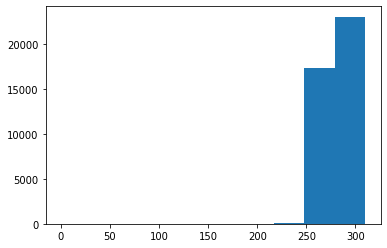

In [16]:
plt.hist(series_data.temp)

Разберемся с выбросами в значениях температур

In [17]:
series_data[series_data.temp == 0]

,traffic_volume,holiday,temp,date_time
11898,361,None,0.0,2014-01-31 03:00:00
11899,734,None,0.0,2014-01-31 04:00:00
11900,2557,None,0.0,2014-01-31 05:00:00
11901,5150,None,0.0,2014-01-31 06:00:00
11946,291,None,0.0,2014-02-02 03:00:00
11947,284,None,0.0,2014-02-02 04:00:00
11948,434,None,0.0,2014-02-02 05:00:00
11949,739,None,0.0,2014-02-02 06:00:00
11950,962,None,0.0,2014-02-02 07:00:00
11951,1670,None,0.0,2014-02-02 08:00:00


In [18]:
series_data[series_data.temp < 245]

,traffic_volume,holiday,temp,date_time
3292,354,None,244.82,2013-02-02 03:00:00
3293,417,None,244.82,2013-02-02 04:00:00
3294,678,None,244.82,2013-02-02 05:00:00
11898,361,None,0.00,2014-01-31 03:00:00
11899,734,None,0.00,2014-01-31 04:00:00
11900,2557,None,0.00,2014-01-31 05:00:00
11901,5150,None,0.00,2014-01-31 06:00:00
11946,291,None,0.00,2014-02-02 03:00:00
11947,284,None,0.00,2014-02-02 04:00:00
11948,434,None,0.00,2014-02-02 05:00:00


In [19]:
series_data['date_time'] = pd.to_datetime(series_data.date_time)

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Выведем данные вокруг "выколотых" точек, чтобы для себя понять их возможные примерные значения

In [20]:
series_data[(series_data.date_time > '2014-01-31 00:00:00') & (series_data.date_time < '2014-01-31 12:00:00')]

,traffic_volume,holiday,temp,date_time
11896,390,None,255.93,2014-01-31 01:00:00
11897,313,None,255.93,2014-01-31 02:00:00
11898,361,None,0.00,2014-01-31 03:00:00
11899,734,None,0.00,2014-01-31 04:00:00
11900,2557,None,0.00,2014-01-31 05:00:00
11901,5150,None,0.00,2014-01-31 06:00:00
11902,5363,None,255.93,2014-01-31 07:00:00
11903,5269,None,255.93,2014-01-31 08:00:00
11904,4721,None,255.93,2014-01-31 09:00:00
11905,4548,None,255.84,2014-01-31 10:00:00


In [21]:
series_data[(series_data.date_time > '2014-02-02 00:00:00') & (series_data.date_time < '2014-02-02 12:00:00')]

,traffic_volume,holiday,temp,date_time
11944,695,None,255.48,2014-02-02 01:00:00
11945,539,None,255.37,2014-02-02 02:00:00
11946,291,None,0.00,2014-02-02 03:00:00
11947,284,None,0.00,2014-02-02 04:00:00
11948,434,None,0.00,2014-02-02 05:00:00
11949,739,None,0.00,2014-02-02 06:00:00
11950,962,None,0.00,2014-02-02 07:00:00
11951,1670,None,0.00,2014-02-02 08:00:00
11952,2506,None,255.62,2014-02-02 09:00:00
11953,3114,None,257.04,2014-02-02 10:00:00


Интерполируем.

In [22]:
interpolated = series_data['temp'].replace(0, np.nan).interpolate()

In [23]:
for i in range(11944, 11955):
    print(interpolated[i])

255.48
255.37
255.40571428571428
255.4414285714286
255.47714285714287
255.51285714285714
255.54857142857142
255.58428571428573
255.62
257.04
258.17


In [24]:
for i in range(11896, 11907):
    print(interpolated[i])

255.93
255.93
255.93
255.93
255.93
255.93
255.93
255.93
255.93
255.84
256.88


Результат интерполяции похож на правду.

In [25]:
series_data['temp'] = interpolated

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
series_data.set_index('date_time', inplace=True)

In [27]:
plot_data = series_data[series_data.index > '2018-09-15']

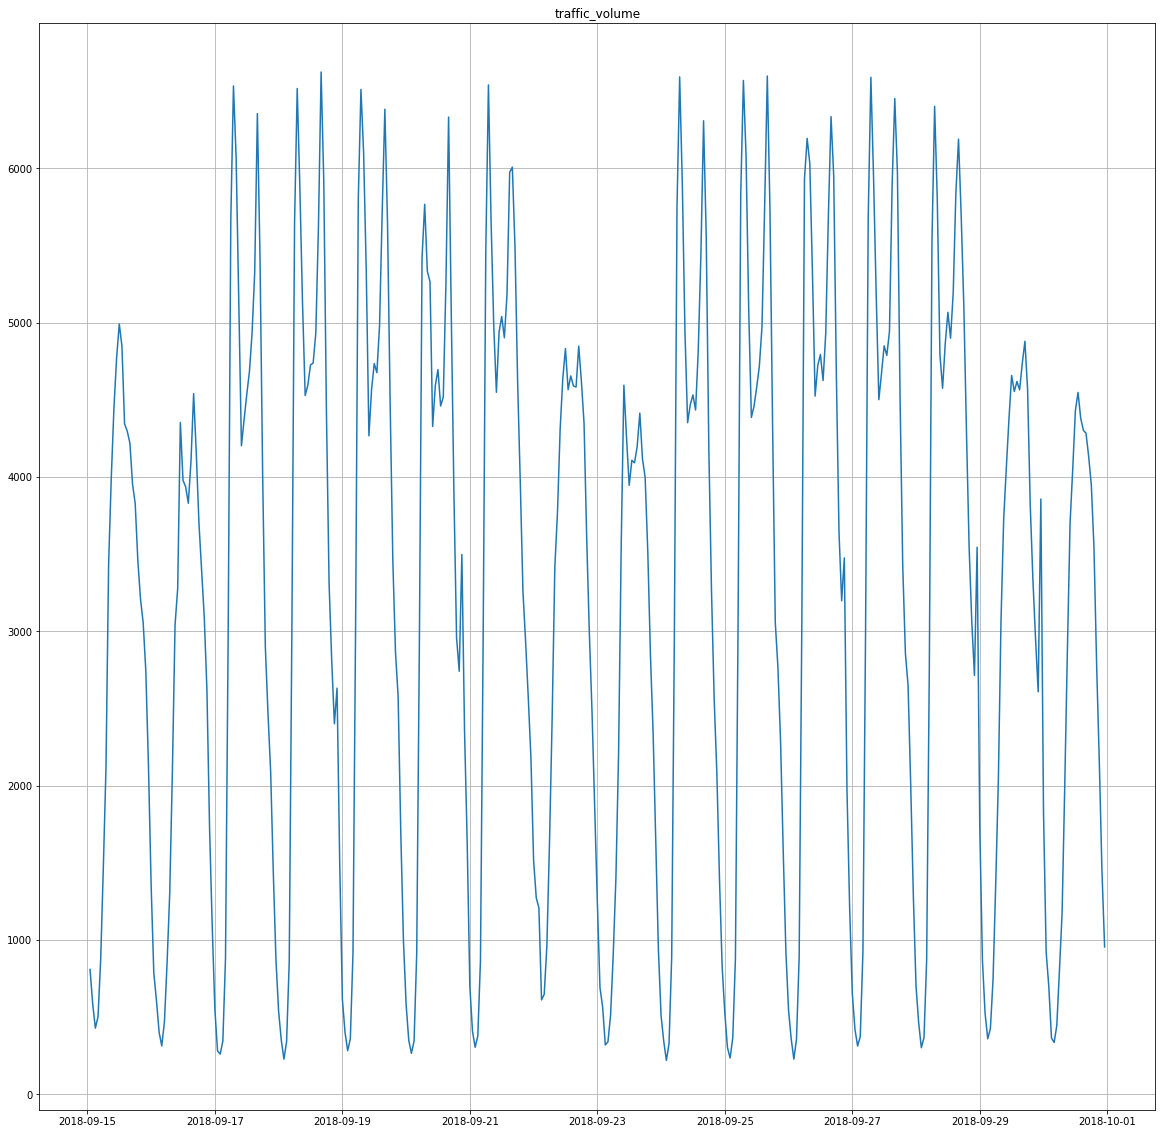

In [28]:
plt.figure(figsize=(20, 20))
plt.plot(plot_data.traffic_volume)
plt.title('traffic_volume')
plt.grid(True)
plt.show()

В течение дня заметны два пика - люди едут на работу/с работы.

<a id='add_features'></a>

## Генерация дополнительных признаков

In [29]:
series_data["hour"] = series_data.index.hour
series_data["weekday"] = series_data.index.weekday
series_data['is_weekend'] = series_data.weekday.isin([5,6])*1
series_data.tail()

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,traffic_volume,holiday,temp,hour,weekday,is_weekend
date_time,,,,,,
2018-09-30 19:00:00,3543,None,283.45,19,6,1
2018-09-30 20:00:00,2781,None,282.76,20,6,1
2018-09-30 21:00:00,2159,None,282.73,21,6,1
2018-09-30 22:00:00,1450,None,282.09,22,6,1
2018-09-30 23:00:00,954,None,282.12,23,6,1


<a id='model'></a>

## Построение модели

In [30]:
X = series_data.drop(['traffic_volume'], axis=1)
y = series_data.traffic_volume

In [31]:
index_1 = '2018-09-16'
index_2 = '2018-09-17'

In [32]:
X_train = X.loc[:index_1]
y_train = y.loc[:index_1]
X_test = X.loc[index_2:]
y_test = y.loc[index_2:]

In [33]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [34]:
X_test.holiday.value_counts()

None    336
Name: holiday, dtype: int64

In [35]:
X_train.holiday.value_counts()

None                         40186
Washingtons Birthday             5
Labor Day                        5
Veterans Day                     5
Independence Day                 5
New Years Day                    5
Columbus Day                     5
Memorial Day                     5
Thanksgiving Day                 5
Christmas Day                    5
State Fair                       5
Martin Luther King Jr Day        3
Name: holiday, dtype: int64

В тесте праздничных дней нет, в трэйне их мало, поэтому, возможно, это не такая важная фича.

In [36]:
le = LabelEncoder()
X_train['holiday'] = le.fit_transform(X_train['holiday'])
X_test['holiday'] = le.transform(X_test['holiday'])

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Для линейной регрессии понадобятся отшкалированные данные

In [37]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [38]:
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

In [39]:
X_train_scaled.index = X_train.index
X_test_scaled.index = X_test.index

<a id='baseline'></a>

## Baseline-модель

In [40]:
avg_data = dict(series_data.groupby(["weekday","hour"])["traffic_volume"].mean())

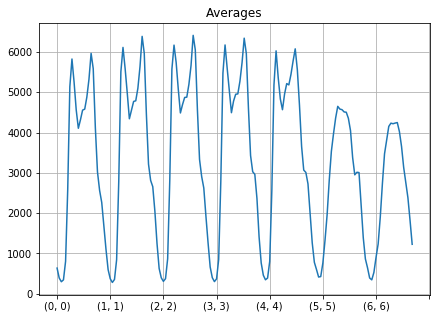

In [41]:
plt.figure(figsize=(7, 5))
plt.title("Averages")
pd.DataFrame.from_dict(avg_data, orient='index')[0].plot()
plt.grid(True);

In [42]:
avg_data

{(0, 0): 633.152610441767,
 (0, 1): 387.35833333333335,
 (0, 2): 294.2926829268293,
 (0, 3): 341.2083333333333,
 (0, 4): 802.2314049586777,
 (0, 5): 2575.522267206478,
 (0, 6): 5138.954732510288,
 (0, 7): 5826.681632653062,
 (0, 8): 5249.4135021097045,
 (0, 9): 4562.906779661017,
 (0, 10): 4106.129166666667,
 (0, 11): 4318.05439330544,
 (0, 12): 4556.821576763486,
 (0, 13): 4581.707112970711,
 (0, 14): 4881.59243697479,
 (0, 15): 5326.238493723849,
 (0, 16): 5966.9747899159665,
 (0, 17): 5587.90756302521,
 (0, 18): 4117.804166666667,
 (0, 19): 3022.004081632653,
 (0, 20): 2562.766666666667,
 (0, 21): 2262.843373493976,
 (0, 22): 1688.6172839506173,
 (0, 23): 1101.2530612244898,
 (1, 0): 595.6816326530612,
 (1, 1): 368.84583333333336,
 (1, 2): 276.7083333333333,
 (1, 3): 351.14285714285717,
 (1, 4): 840.6296296296297,
 (1, 5): 2774.719827586207,
 (1, 6): 5508.26359832636,
 (1, 7): 6114.837004405286,
 (1, 8): 5591.516949152542,
 (1, 9): 4983.448275862069,
 (1, 10): 4342.578512396694,
 (1

In [43]:
y_test

date_time
2018-09-17 00:00:00     550
2018-09-17 01:00:00     280
2018-09-17 02:00:00     260
2018-09-17 03:00:00     344
2018-09-17 04:00:00     880
                       ... 
2018-09-30 19:00:00    3543
2018-09-30 20:00:00    2781
2018-09-30 21:00:00    2159
2018-09-30 22:00:00    1450
2018-09-30 23:00:00     954
Name: traffic_volume, Length: 336, dtype: int64

Используем функцию ошибки из вебинара.

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
y_pred = avg_data.values()

In [46]:
y_test[:'2018-09-23'].tail()

date_time
2018-09-23 19:00:00    3516
2018-09-23 20:00:00    2846
2018-09-23 21:00:00    2346
2018-09-23 22:00:00    1635
2018-09-23 23:00:00     934
Name: traffic_volume, dtype: int64

In [47]:
X_test['2018-09-17']

,holiday,temp,hour,weekday,is_weekend
date_time,,,,,
2018-09-17 00:00:00,7,296.58,0,0,0
2018-09-17 01:00:00,7,296.19,1,0,0
2018-09-17 02:00:00,7,295.82,2,0,0
2018-09-17 03:00:00,7,295.83,3,0,0
2018-09-17 04:00:00,7,295.68,4,0,0
2018-09-17 05:00:00,7,295.35,5,0,0
2018-09-17 06:00:00,7,294.90,6,0,0
2018-09-17 07:00:00,7,293.45,7,0,0
2018-09-17 08:00:00,7,293.91,8,0,0


In [48]:
 mean_absolute_percentage_error(y_test[:'2018-09-23'], list(avg_data.values()))

8.65037496954426

__Наша baseline модель дает ошибку 8.65037496954426__

<a id='lr_base'></a>

## Линейная регрессия

Mean absolute percentage error 49.21%


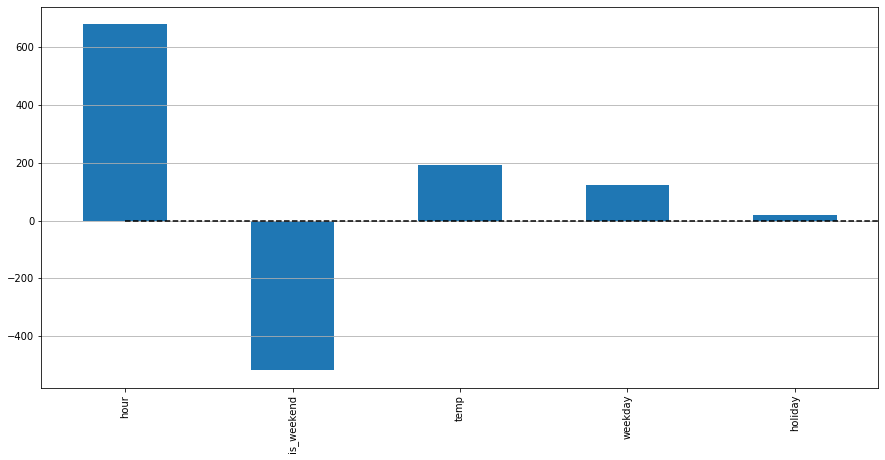

In [49]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
prediction = lr_scaled.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lr_scaled)

<a id='ridge_base'></a>

## RidgeCV

Mean absolute percentage error 49.21%


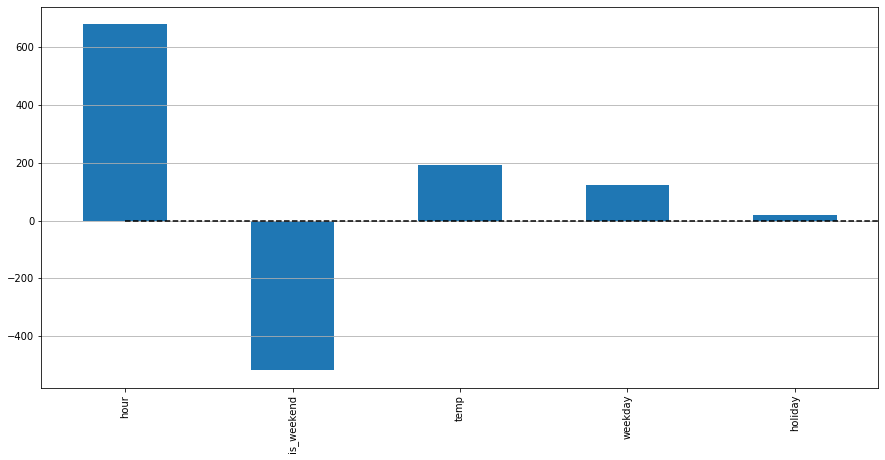

In [50]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train_scaled, y_train)
prediction = ridge.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(ridge)

<a id='lasso_base'></a>

## LassoCV

Mean absolute percentage error 49.22%


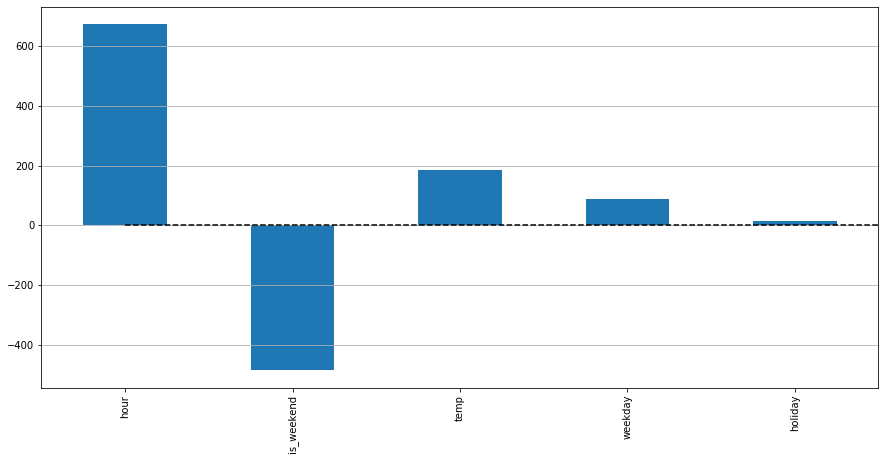

In [51]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train_scaled, y_train)
prediction = lasso.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lasso)

Линейные модели дают очень большую ошибку.

<a id='boosting_base'></a>

## Boosting

In [52]:
gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train, y_train)
prediction = gbr.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 24.63%


In [53]:
catboost = CatBoostRegressor(iterations=100, learning_rate=0.3,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 8.82%


Результаты для бустинг моделей гораздо лучше. Попробуем вручную улучшить результаты CatBoostRegressor.

In [54]:
catboost = CatBoostRegressor(iterations=300, learning_rate=0.3,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 8.73%


In [55]:
catboost = CatBoostRegressor(iterations=200, learning_rate=0.4,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 8.65%


Мы получили результат, идентиный baseline модели. Попробуем улучшить его добавлением признаков-лагов.

<a id='lag_added'></a>

## Добавление признаков-лагов

In [56]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(series_data.copy())
data.columns = series_data.columns

In [57]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.traffic_volume.shift(i)

In [58]:
data.tail(7)

,traffic_volume,holiday,temp,hour,weekday,is_weekend,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-30 17:00:00,4132,None,284.79,17,6,1,4049.0,3701.0,2882.0,2002.0,...,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,3818.0,4569.0,4878.0
2018-09-30 18:00:00,3947,None,284.20,18,6,1,4429.0,4049.0,3701.0,2882.0,...,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,3818.0,4569.0
2018-09-30 19:00:00,3543,None,283.45,19,6,1,4547.0,4429.0,4049.0,3701.0,...,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,3818.0
2018-09-30 20:00:00,2781,None,282.76,20,6,1,4380.0,4547.0,4429.0,4049.0,...,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0
2018-09-30 21:00:00,2159,None,282.73,21,6,1,4302.0,4380.0,4547.0,4429.0,...,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0
2018-09-30 22:00:00,1450,None,282.09,22,6,1,4283.0,4302.0,4380.0,4547.0,...,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0
2018-09-30 23:00:00,954,None,282.12,23,6,1,4132.0,4283.0,4302.0,4380.0,...,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0


In [59]:
X = data.dropna().drop(['traffic_volume'], axis=1)
y = data.dropna().traffic_volume

In [60]:
index_1 = '2018-09-16'
index_2 = '2018-09-17'

In [61]:
X_train = X.loc[:index_1]
y_train = y.loc[:index_1]
X_test = X.loc[index_2:]
y_test = y.loc[index_2:]

Подготовим данные.

In [62]:
le = LabelEncoder()
X_train['holiday'] = le.fit_transform(X_train['holiday'])
X_test['holiday'] = le.transform(X_test['holiday'])

C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dinak\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [64]:
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

In [65]:
X_train_scaled.index = X_train.index
X_test_scaled.index = X_test.index

In [66]:
X_test.tail()

,holiday,temp,hour,weekday,is_weekend,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-30 19:00:00,7,283.45,19,6,1,4547.0,4429.0,4049.0,3701.0,2882.0,...,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0,3818.0
2018-09-30 20:00:00,7,282.76,20,6,1,4380.0,4547.0,4429.0,4049.0,3701.0,...,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0,3338.0
2018-09-30 21:00:00,7,282.73,21,6,1,4302.0,4380.0,4547.0,4429.0,4049.0,...,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0,2950.0
2018-09-30 22:00:00,7,282.09,22,6,1,4283.0,4302.0,4380.0,4547.0,4429.0,...,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0,2607.0
2018-09-30 23:00:00,7,282.12,23,6,1,4132.0,4283.0,4302.0,4380.0,4547.0,...,2002.0,1175.0,802.0,444.0,335.0,364.0,696.0,920.0,1826.0,3856.0


In [67]:
X_train_scaled.head()

,holiday,temp,hour,weekday,is_weekend,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-03 12:00:00,0.014523,0.809414,0.069807,-0.504137,-0.632841,-1.472516,-1.519783,-1.495515,-1.402244,-1.171978,...,0.745781,1.260022,1.372782,1.155624,0.952580,0.820059,0.874419,0.743909,0.617430,1.135740
2012-10-03 13:00:00,0.014523,0.905311,0.213691,-0.504137,-0.632841,-1.247326,-1.472429,-1.519695,-1.495436,-1.402185,...,0.125690,0.745723,1.259950,1.372726,1.155581,0.952541,0.820015,0.874381,0.743874,0.617375
2012-10-03 14:00:00,0.014523,0.987508,0.357574,-0.504137,-0.632841,-0.288128,-1.247245,-1.472342,-1.519616,-1.495376,...,-0.254626,0.125642,0.745656,1.259893,1.372686,1.155546,0.952499,0.819976,0.874347,0.743818
2012-10-03 15:00:00,0.014523,1.052962,0.501458,-0.504137,-0.632841,1.200543,-0.288072,-1.247163,-1.472264,-1.519556,...,-0.467703,-0.254668,0.125581,0.745598,1.259851,1.372655,1.155507,0.952462,0.819941,0.874291
2012-10-03 16:00:00,0.014523,1.049918,0.645341,-0.504137,-0.632841,1.622710,1.200559,-0.288013,-1.247090,-1.472204,...,-0.886806,-0.467742,-0.254724,0.125522,0.745549,1.259818,1.372620,1.155473,0.952429,0.819885


<a id='lr_lag'></a>

## Линейная регрессия

Mean absolute percentage error 68.50%


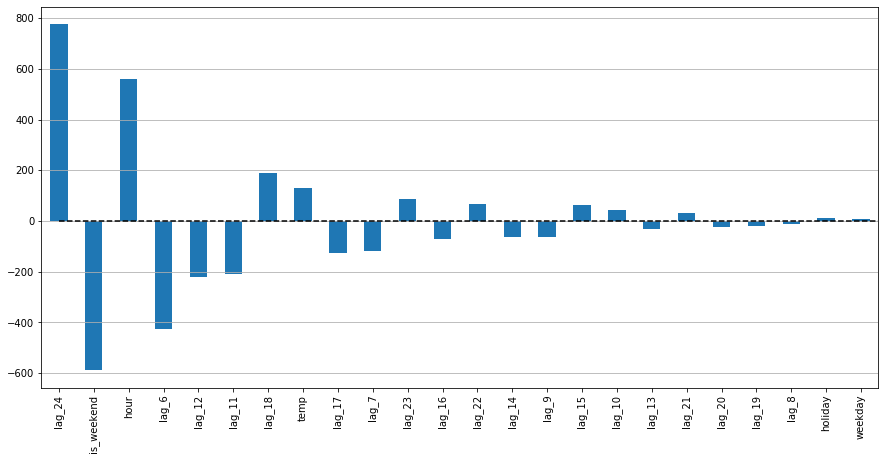

In [68]:
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lr)

<a id='ridge_lag'></a>

## RidgeCV

Mean absolute percentage error 67.04%


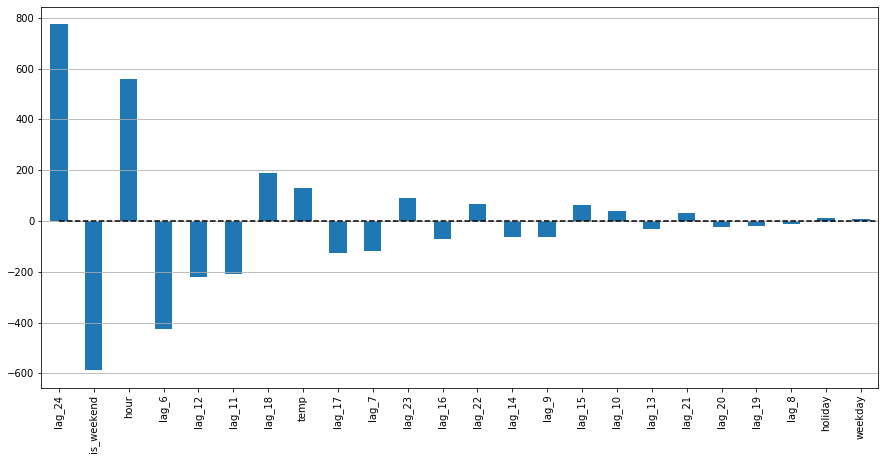

In [69]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train_scaled, y_train)
prediction = ridge.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(ridge)

<a id='lasso_lag'></a>

## LassoCV

Mean absolute percentage error 129.49%


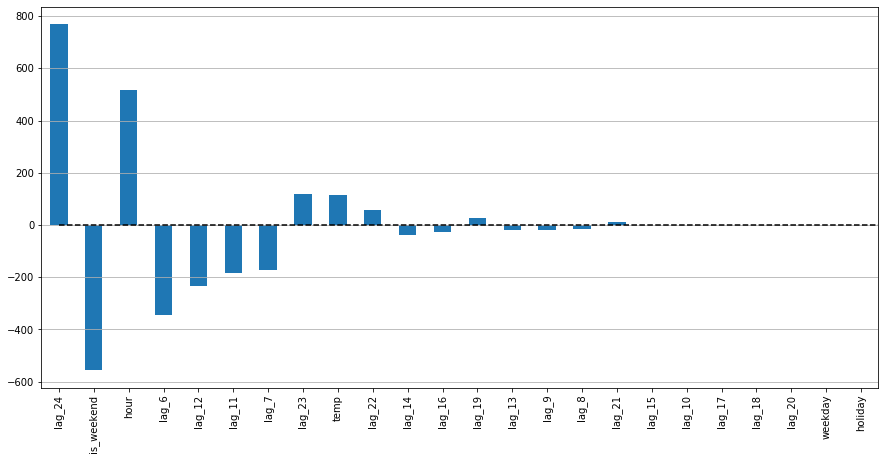

In [70]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train_scaled, y_train)
prediction = lasso.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lasso)

Mean absolute percentage error 29.96%


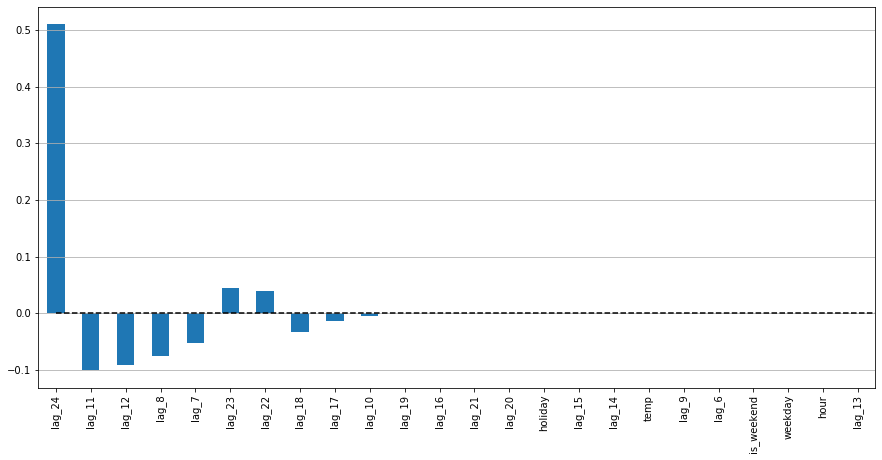

In [71]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)
prediction = lasso.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lasso)

Добавление лагов еще больше увеличивает значение ошибки для линейных моделей.

<a id='boosting_lag'></a>

## Boosting

In [72]:
gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train, y_train)
prediction = gbr.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 25.58%


In [73]:
catboost = CatBoostRegressor(iterations=100, learning_rate=0.5,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 8.99%


Попробуем вручную уменьшить ошибку

Mean absolute percentage error 8.17%


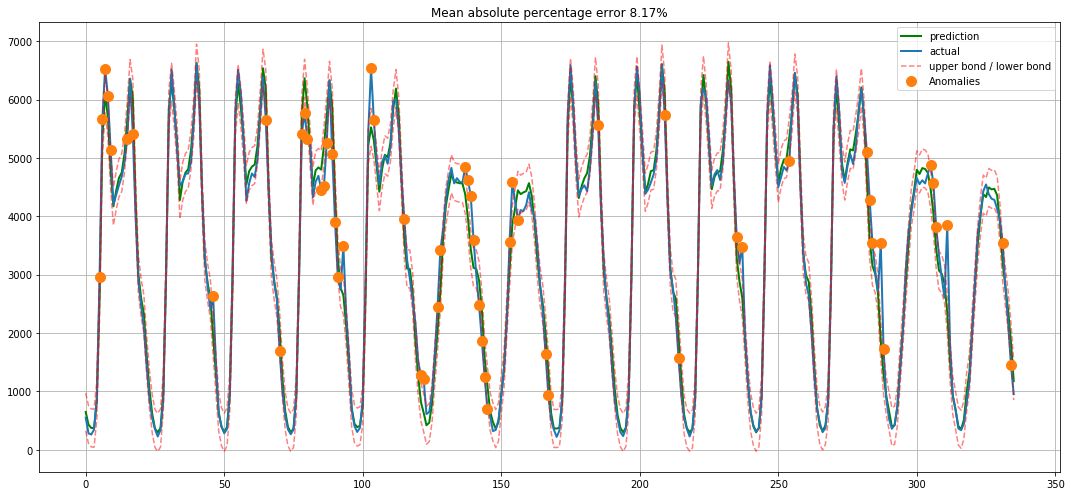

In [74]:
catboost = CatBoostRegressor(iterations=500, learning_rate=0.1,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotModelResults(catboost, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

Немного улучшили значение ошибки, незначительно побили baseline.

Возможно, у нас возникает переобучение. Попробуем уменьшить размер тренировоного датасета.

<a id='less_dataset'></a>

## Уменьшение объема датасета

Возьмем данные только за последний год.

In [75]:
index_1 = '2018-09-16'
index_2 = '2018-09-17'

In [76]:
X_train = X_train.loc['2018-01-01':index_1]
y_train = y_train.loc['2018-01-01':index_1]
X_test = X_test.loc[index_2:]
y_test = y_test.loc[index_2:]

In [77]:
X_train_scaled = X_train_scaled.loc['2018-01-01':index_1]
X_test_scaled = X_test_scaled.loc[index_2:]

<a id='lr_less'></a>

## Линейная регрессия

Mean absolute percentage error 47.84%


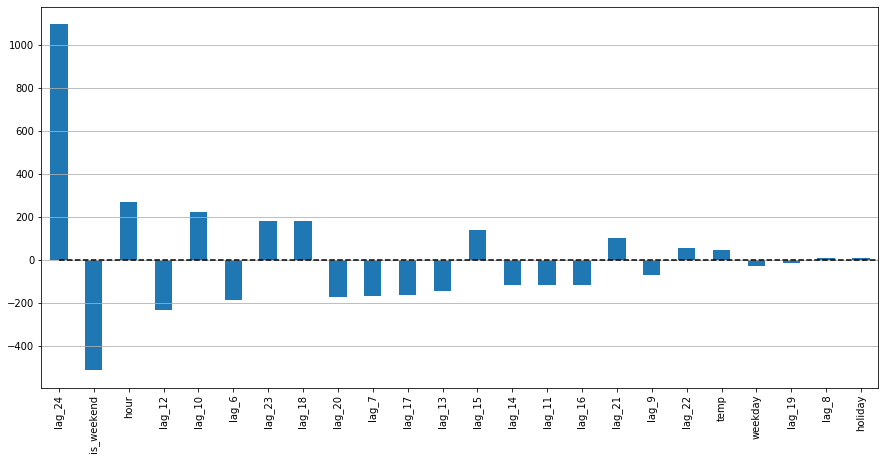

In [78]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lr)

<a id='ridge_less'></a>

## RidgeCV

Mean absolute percentage error 47.86%


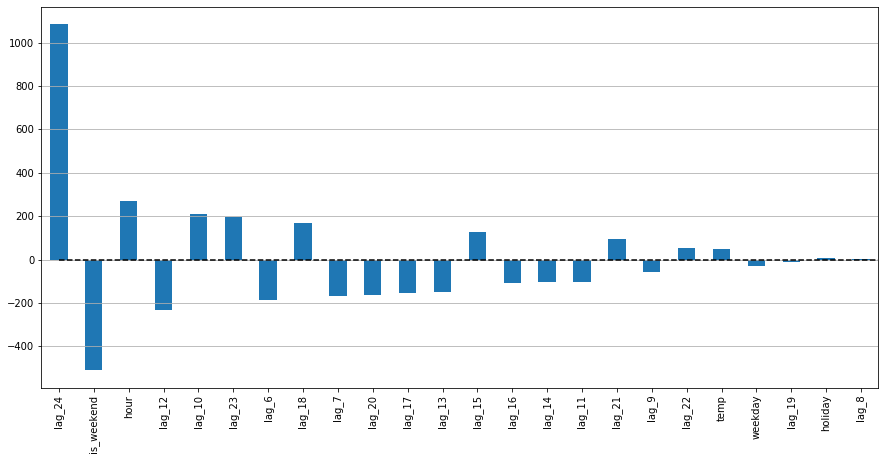

In [79]:
ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train_scaled, y_train)
prediction = ridge.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(ridge)

<a id='lasso_less'></a>

## LassoCV

Mean absolute percentage error 27.12%


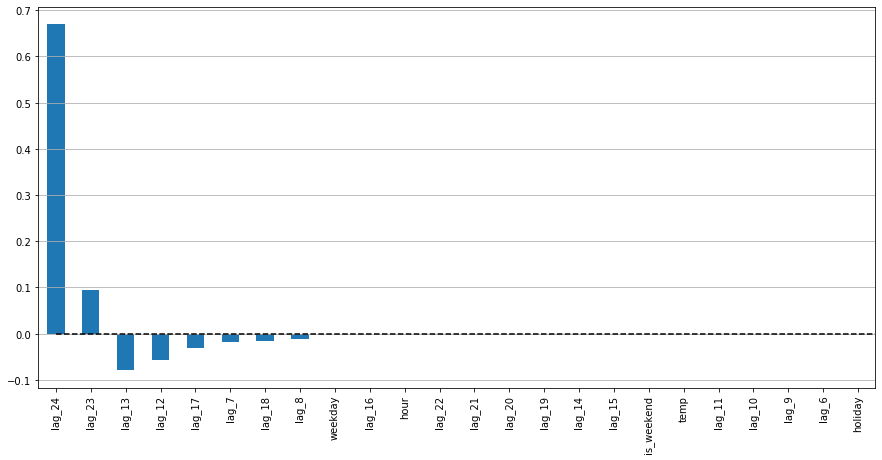

In [80]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)
prediction = lasso.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lasso)

Mean absolute percentage error 120.21%


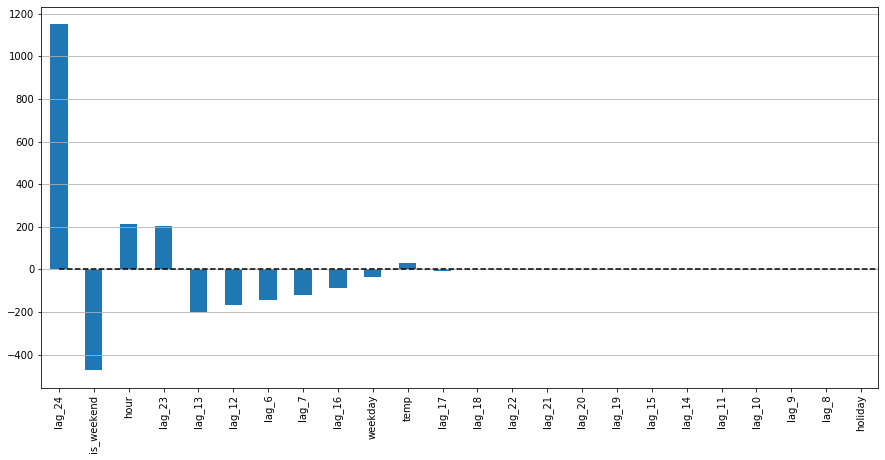

In [81]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train_scaled, y_train)
prediction = lasso.predict(X_test_scaled)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))
plotCoefficients(lasso)

Уменьшение объема тренировочного датасета немного улучшает результат линейных систем, однако очевидно, что эти модели не подходят для решения данной задачи. Наблюдается странный эффект, когда использование для лассо нешкалированных данных значительно уменьшило ошибку.

<a id='boosting_less'></a>

## Boosting

In [82]:
gbr = AdaBoostRegressor(n_estimators=300)
gbr.fit(X_train, y_train)
prediction = gbr.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 20.96%


In [83]:
catboost = CatBoostRegressor(iterations=500, learning_rate=0.2,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 9.32%


In [84]:
catboost = CatBoostRegressor(iterations=500, learning_rate=0.25,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train, y_train, verbose=0)
prediction = catboost.predict(X_test)
error = mean_absolute_percentage_error(prediction, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

Mean absolute percentage error 9.60%


Уменьшение объема тренировочного датасета немного улучшило ошибку для AdaBoost Regressor, однако CatBoostRegressor ухудшился. Результата baseline модели в таком случае не достигаем.

<a id='gluonts'></a>

## GluonTS

In [94]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": X_train.index[0], "target": y_train}],
    freq = "H"
)

In [95]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="H", 
    prediction_length=30, 
    trainer=Trainer(epochs=20)
)
predictor = estimator.train(training_data=training_data)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s, epoch=20/20, avg_epoch_loss=6.83]


In [97]:
len(y_test)

336

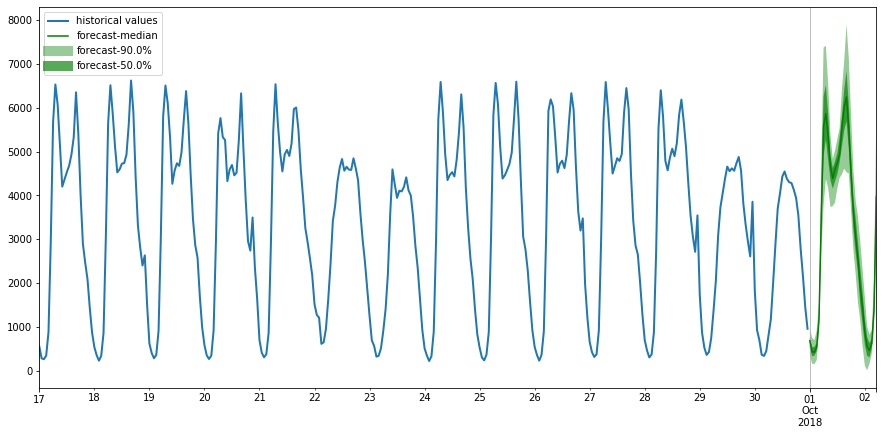

In [103]:
from gluonts.dataset.util import to_pandas

test_data = ListDataset(
    [{"start": X_test.index[0], "target": y_test}],
    freq = "H"
)

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(15, 7), label="historical values")
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')

In [99]:
test_data.list_data

[{'start': Timestamp('2018-09-17 00:00:00'),
  'target': date_time
  2018-09-17 00:00:00     550
  2018-09-17 01:00:00     280
  2018-09-17 02:00:00     260
  2018-09-17 03:00:00     344
  2018-09-17 04:00:00     880
                         ... 
  2018-09-30 19:00:00    3543
  2018-09-30 20:00:00    2781
  2018-09-30 21:00:00    2159
  2018-09-30 22:00:00    1450
  2018-09-30 23:00:00     954
  Name: traffic_volume, Length: 336, dtype: int64}]

Применена библиотека GluonTS к нашей задаче. Нарисованы правдоподобные графики:)

<a id='conclusion'></a>

## Выводы

1. Baseline модель дает ошибку 8.65037496954426.
2. Линейные модели дают очень большую ошибку. Добавление лагов еще больше увеличивает значение ошибки для линейных моделей.
3. Уменьшение объема тренировочного датасета немного улучшает результат линейных систем, однако очевидно, что эти модели не подходят для решения данной задачи. Наблюдается странный эффект, когда использование для лассо нешкалированных данных значительно уменьшило ошибку.
4. С помощью бустинга можно добиться результата baseline модели и немного улучшить его. Уменьшение объема тренировоного датасета немного улучшило ошибку для AdaBoost Regressor, однако CatBoostRegressor ухудшился. Результата baseline модели в таком случае не достигаем.